<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [ ]:
# Installation
!pip install -q yfinance
!pip install -q yahoo_fin --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.6 MB/s eta 0:00:00


In [ ]:
import random

## Hyper parameters
history = "10y"
buy_trigger = 3                           # times standard deviation
sell_trigger = 1                          # times the avg cost of the security to grow before we sell
security_age = 15                         # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000                # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"                         # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5                     # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 1                   # number of backtests to run
backtest_days = random.sample(range(500, 600), backtest_iterations) # starting days for back testing
backtest_days.sort()
prefer_beta = True
above_beta_mean = False

starting_balance = 10000                  # seed money to start investing
current_account = original_balance = starting_balance
portfolio = {}

# Display test results. Debugging Tools
print_final_portfolio = False             # Prints the portfolio list at the end of each backtest iteration
plot_every_test_graph = True              # Prints the model performance during the back end against s&P500
plot_summary_graph = True                 # prints the summary graph
dump_all_trades = False                   # dumps all sells at the end of the trade. Use it sparingly, with iteration set to 1

# Deploy the initial amount gradually
tranche_pct = 25                          # of amount to deploy
tranche_period = 7                        # calender days between deployment


In [ ]:
tests = [
    {
        "Name": "Test 1",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1000,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 2",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 3",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 4",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 5",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 6",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
    {
        "Name": "Test 7",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "",
        "above_beta_mean": False,
     },
     {
        "Name": "Test 8",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1000,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
      {
        "Name": "Test 9",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 20,
        "lockin_gains_factor": 1000,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": True,
     },
     {
        "Name": "Test 10",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 20,
        "lockin_gains_factor": 1000,
        "prefer_beta": True,
        "mean_type": "+ve",
        "above_beta_mean": False,
     },
]

tests_to_run = [8, 10]

In [ ]:
import yfinance as yahooFinance
import yahoo_fin.stock_info as si
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=4)

stocks = si.tickers_sp500()
indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

betas = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/betas.csv")
betas = betas.drop(['index', 'Attribute', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
betas = betas.rename(columns={"Recent": "Beta"})
betas = betas.set_index('Ticker')

for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock] = (d['Close'] - d['Open']) * 100/d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()


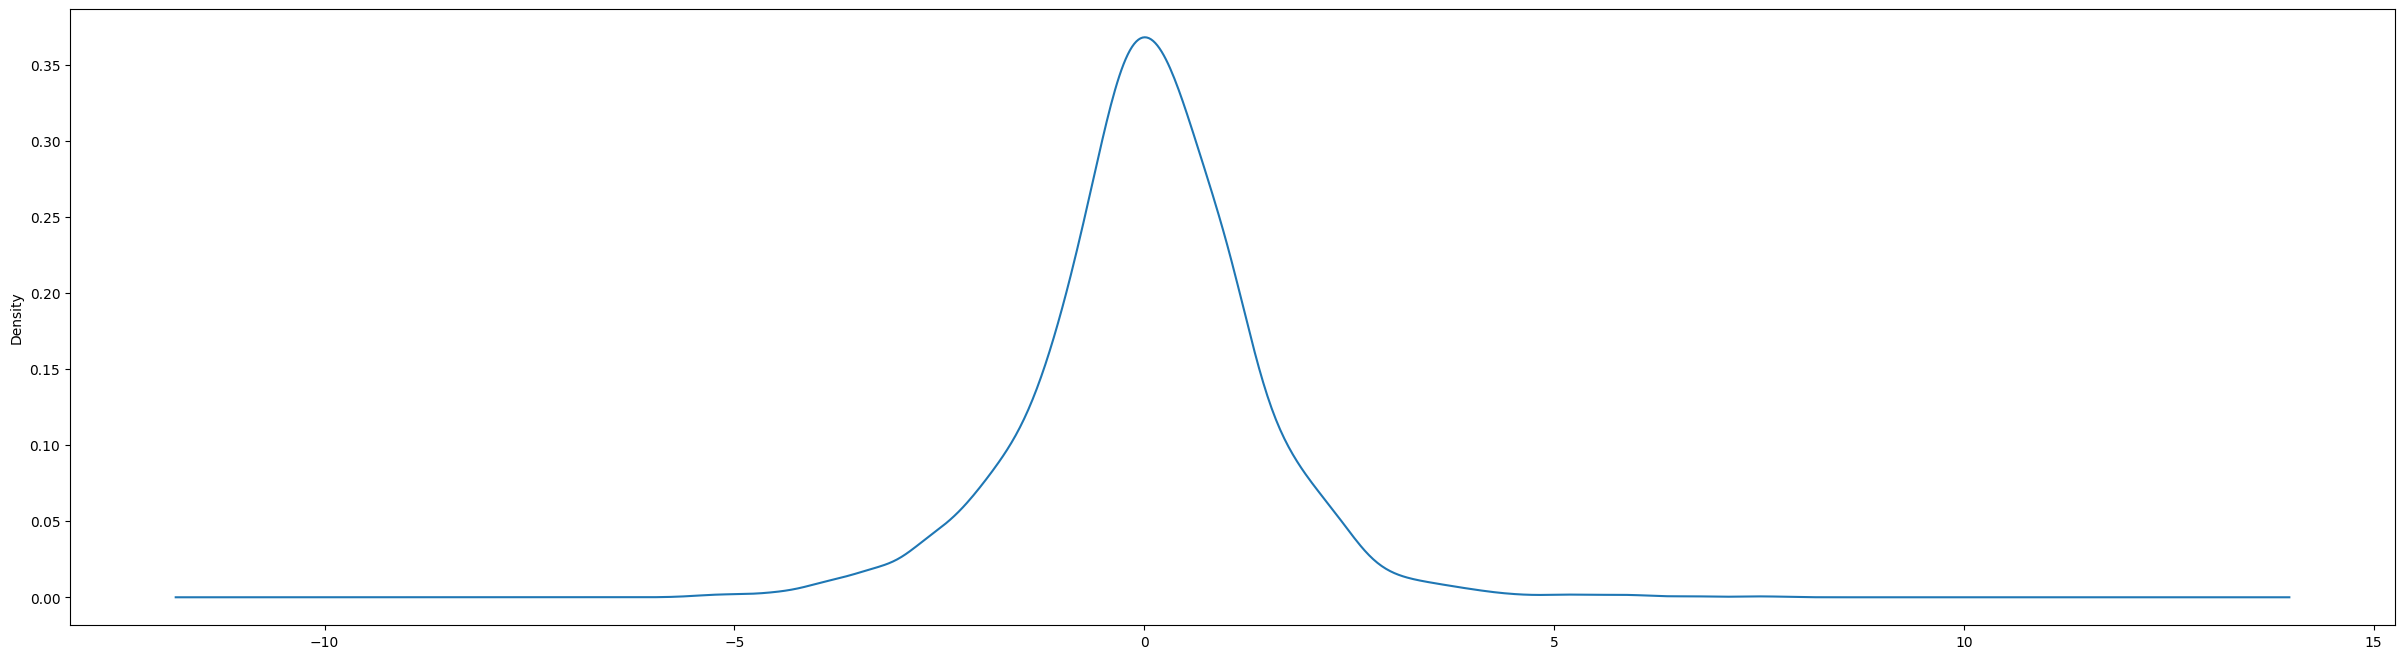

In [ ]:

for stock in stocks[:1]:
    #latest[stock] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']

    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock, title="Stocks Daily Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock, data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();

In [ ]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]
betas_mean = betas.describe()['Beta']['mean']

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title="Daily Stock Price change", markers=True)
fig.show()
fig = px.line(betas, title="Stocks Betas", markers=True)
fig.show()


In [ ]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio, security_profit, security_loss):
  latest = {}
  for s in stocks:
      latest[s] = (stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"])* 100 /stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean_type != "+ve" or mean['mean'] > 0) & (latest_diff['diff'] < 0) &
                                 (above_beta_mean == False or betas_mean >= betas['Beta']) &
                                 (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)
  latest_diff['beta'] = betas['Beta']

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  profit = loss = 0
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s] * avg / 100 <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        profit = len(portfolio[s]['costs']) * stocks_ts.loc[index, s+"_Close"] - sum(portfolio[s]['costs'])
        if dump_all_trades:
          print("Selling %s (beta %f) at profit. closing price %f. profit %f days %d" %
                (s, betas['Beta'][s], stocks_ts.loc[index, s+"_Close"], profit, t.days), portfolio[s])
        security_profit.loc[len(security_profit.index)] = {'beta':betas['Beta'][s], 'days':t.days, 'profit':profit}
        latest_diff.at[s, 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        loss = len(portfolio[s]['costs']) * stocks_ts.loc[index, s+"_Close"] - sum(portfolio[s]['costs'])
        if dump_all_trades:
          print("Dumping %s(beta %f) because of age. closing price %f. loss %f" %
                (s, betas['Beta'][s], stocks_ts.loc[index, s+"_Close"], loss),
                portfolio[s])
        security_loss.loc[len(security_loss.index)] = {'beta':betas['Beta'][s], 'loss':loss}
        latest_diff.at[s, 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  sell_stocks = latest_diff[latest_diff['sell']]
  buy_stocks = latest_diff[latest_diff['buy']]
  if prefer_beta:
    buy_stocks = buy_stocks.sort_values('beta',ascending=False)
  return sell_stocks, buy_stocks


In [ ]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  stocks_bought = pd.DataFrame(columns=stocks)
  stocks_sold = pd.DataFrame(columns=stocks)
  stocks_profit = pd.DataFrame(columns=['beta', 'days', 'profit'])
  stocks_loss = pd.DataFrame(columns=['beta', 'loss'])

  original_balance = starting_balance
  current_account = 0
  portfolio = {}
  capital_to_be_deployed = original_balance

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  cash_inhand = []
  for backtest_start_date in stocks_ts.index[idx:]:
      t = backtest_start_date - stocks_ts.index[idx]
      if (capital_to_be_deployed > 0) & (t.days % tranche_period == 0):
        current_account += min(tranche_pct * starting_balance / 100, capital_to_be_deployed)
        capital_to_be_deployed -= min(tranche_pct * starting_balance / 100, capital_to_be_deployed)
        #print("Day of deployment %d, current_account %d, deployed_capital %d" % (t.days, current_account, capital_to_be_deployed))
      sell, buy = getsellbuy(backtest_start_date, portfolio, stocks_profit, stocks_loss)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          stocks_sold.loc[backtest_start_date, stock] = portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. Beta
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          stocks_bought.loc[backtest_start_date, stock] = max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          for i in range(max_stocks_to_buy):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      cash_inhand.append(current_account)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
            stocks_sold.loc[backtest_start_date, stock] = stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)

  if dump_all_trades:
    print(stocks_profit)
    print(stocks_loss)
  print("Profit Distribution")
  print("===================")
  print(stocks_profit.describe())
  print()
  print("Loss Distribution")
  print("=================")
  print(stocks_loss.describe())
  print("Total Profit %f and Total Loss %f" % (stocks_profit['profit'].sum(), stocks_loss['loss'].sum()))
  #stocks_sold.to_csv("/content/drive/MyDrive/Colab Notebooks/sold.csv")
  #stocks_bought.to_csv("/content/drive/MyDrive/Colab Notebooks/bought.csv")
  return calculate_networth(backtest_start_date), current_account, price_movement, cash_inhand

In [ ]:

def run_backtest():
  nws = {}
  sp_ret = {}
  for i in backtest_days:
    tradingdays_togoback = i
    networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
    # normalize s&p500 for starting balance
    idx_list = list(indices_ts.loc[indices_ts.index[-tradingdays_togoback:], "^GSPC_Close"] * starting_balance/indices_ts.loc[indices_ts.index[-tradingdays_togoback], "^GSPC_Close"])
    pm_pct = (pm[-1]-starting_balance)*100/starting_balance
    d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
    d.index = indices_ts.index[-tradingdays_togoback:]
    idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
    print("Total networth: %d (Cash %d) after going back %d days (%s)" % (networth, current_account, tradingdays_togoback, stocks_ts.index[-tradingdays_togoback]))
    print("Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct))
    if print_final_portfolio:
      pp.pprint(portfolio)
    nws[i] = networth
    sp_ret[i] = idx_list[-1]
    if plot_every_test_graph:
      fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%% starting at %s" % (pm_pct, idx_pct, stocks_ts.index[-tradingdays_togoback]), markers=True)
      fig.show()

  if plot_summary_graph:
    plt.plot(nws.keys(), nws.values(), color="green", label='Model')
    plt.plot(sp_ret.keys(), sp_ret.values(), color="blue", label='S&P 500')
    plt.title("Networth at the end of each iteration")
    plt.xlabel('Days') 
    plt.ylabel('Networth')
    plt.legend()
    plt.show()
    print(sum(nws.values())/len(nws))
    idx_list = []
    for i in backtest_days:
      idx_list.append(indices_ts.index[-i])
    summary = pd.DataFrame(data={"Model":nws.values(), "S&P":sp_ret.values()}, 
                           index=list(idx_list))
    fig = px.line(summary, title="Model vs S&P Backtesting Results", markers=True)
    fig.show()
    

Test Parameters for Test 8
{   'Name': 'Test 8',
    'above_beta_mean': False,
    'buy_trigger': 2,
    'lockin_gains_factor': 1000,
    'mean_type': '+ve',
    'prefer_beta': True,
    'security_age': 90,
    'sell_trigger': 1}
Profit Distribution
             beta        days      profit
count  675.000000  675.000000  675.000000
mean     1.171422   12.362963   17.117922
std      0.448966   17.830893   21.698992
min      0.000000    1.000000    0.528088
25%      0.850000    2.000000    6.086121
50%      1.150000    5.000000   11.500015
75%      1.475000   14.000000   19.844131
max      2.880000   91.000000  252.683411

Loss Distribution
            beta         loss
count  63.000000    63.000000
mean    1.150476  -116.128580
std     0.417459   177.754478
min     0.180000 -1019.250031
25%     0.955000  -119.151878
50%     1.110000   -55.681515
75%     1.340000   -26.403170
max     2.490000    -1.058693
Total Profit 11554.597511 and Total Loss -7316.100535
Total networth: 13476 (Cash 2

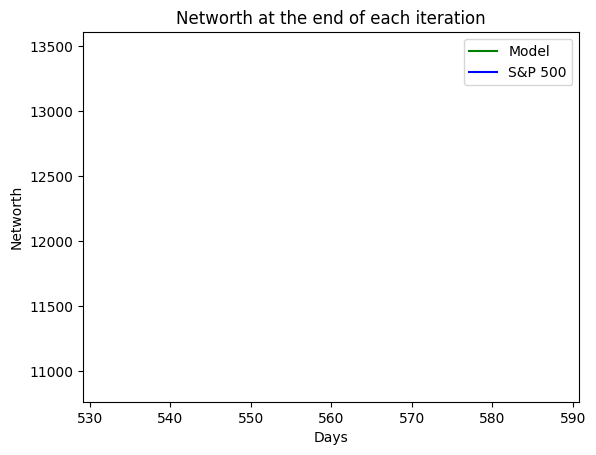

13476.476864814758




Test Parameters for Test 10
{   'Name': 'Test 10',
    'above_beta_mean': False,
    'buy_trigger': 2,
    'lockin_gains_factor': 1000,
    'mean_type': '+ve',
    'prefer_beta': True,
    'security_age': 20,
    'sell_trigger': 1}
Profit Distribution
             beta        days      profit
count  987.000000  987.000000  987.000000
mean     1.161114    5.444782   21.971469
std      0.433033    5.123004   28.973965
min      0.000000    1.000000    0.528088
25%      0.850000    1.000000    7.234039
50%      1.140000    4.000000   13.305588
75%      1.460000    7.000000   26.355896
max      2.880000   21.000000  381.750031

Loss Distribution
             beta        loss
count  345.000000  345.000000
mean     1.165362  -47.913222
std      0.424093   69.915519
min      0.000000 -499.649963
25%      0.930000  -58.349915
50%      1.160000  -24.550018
75%      1.450000   -7.805672
max      2.880000   23.450012
Total Profit 21685.839806 and Total Loss -16530.061464
Total networth: 14882 (C

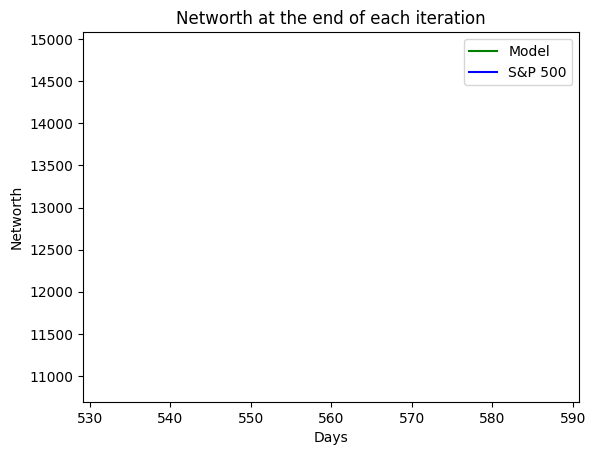

14882.678146362305


In [ ]:

for i in tests_to_run:
  t = tests[i-1]
  buy_trigger = t['buy_trigger']    # times standard deviation
  sell_trigger = t['sell_trigger']   # times the avg cost of the security to grow before we sell
  security_age = t['security_age']  # number of days to hold the security before we cut the losses
  lockin_gains_factor = t['lockin_gains_factor'] # times the orignal amount to grow before we lockin the gains.
  prefer_beta = t['prefer_beta']
  mean_type = t["mean_type"]
  above_beta_mean = t["above_beta_mean"]
  print("Test Parameters for " + t['Name'])
  print("=================================")
  pp.pprint(t)
  run_backtest()
  print()
  print("==================================\n")